In [1]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [3]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [4]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results

# Setup

## variables

In [5]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Taylor Rule

In [6]:
taylor_df = load_taylor()

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)


In [7]:
taylor_df

,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name
DATE,,,,,,,,,,,,,
1960-03-31,3.933333,5.133333,3.873333,3517.181,3255.290989,1.3,-0.7,8.045057,-0.133333,6.972528,2.883333,False,Martin
1960-06-30,3.696667,5.233333,2.993333,3498.246,3288.916718,1.4,-0.6,6.364688,-0.233333,6.282344,2.983333,True,Martin
1960-09-30,2.936667,5.533333,2.360000,3515.385,3321.957785,1.4,-0.6,5.822687,-0.533333,6.011344,2.833333,True,Martin
1960-12-31,2.296667,6.266667,2.306667,3470.278,3353.814414,1.3,-0.7,3.472571,-1.266667,4.686285,2.316667,True,Martin
1961-03-31,2.003333,6.800000,2.350000,3493.703,3385.151548,1.1,-0.9,3.206694,-1.800000,4.253347,1.750000,False,Martin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.770000,3.600000,1.076667,21708.160,20153.810000,7.7,5.7,7.712437,1.400000,16.406219,13.250000,False,Powell
2022-09-30,2.190000,3.566667,2.663333,21851.134,20245.660000,7.3,5.3,7.929966,1.433333,15.914983,12.666667,False,Powell
2022-12-31,3.653333,3.600000,4.040000,21989.981,20334.210000,6.4,4.4,8.142785,1.400000,14.671392,11.300000,False,Powell


## Original Taylor Rule

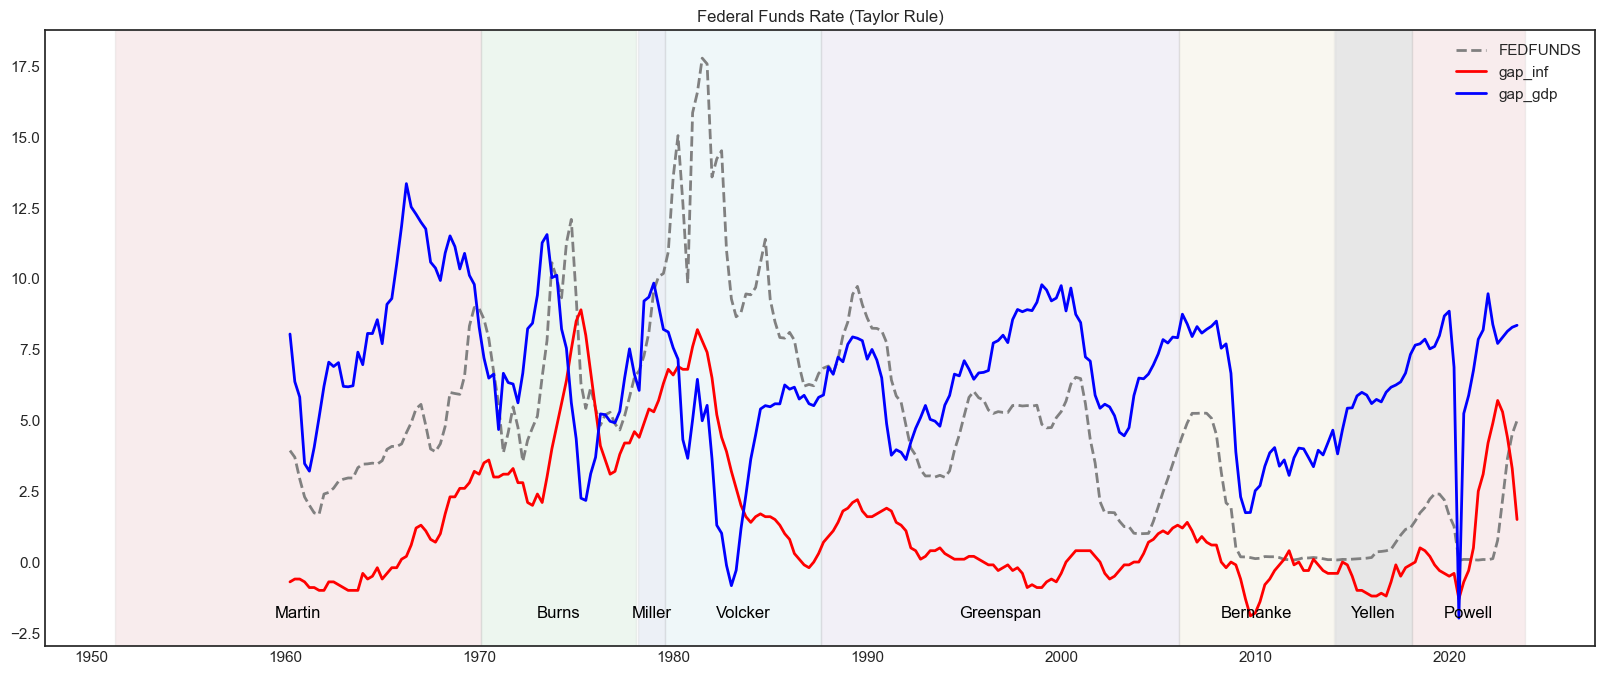

In [8]:
#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor_df
chair_df = get_fed_chair()

cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_inf','gap_gdp']].values.min()


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['gap_inf'], color='red',linewidth=2)
ax.plot(t_df.index, t_df['gap_gdp'], color='blue',linewidth=2)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=12, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","gap_inf",'gap_gdp'])
ax.set(title='Federal Funds Rate (Taylor Rule)');
#plt.legend()
plt.grid(False)
plt.show()

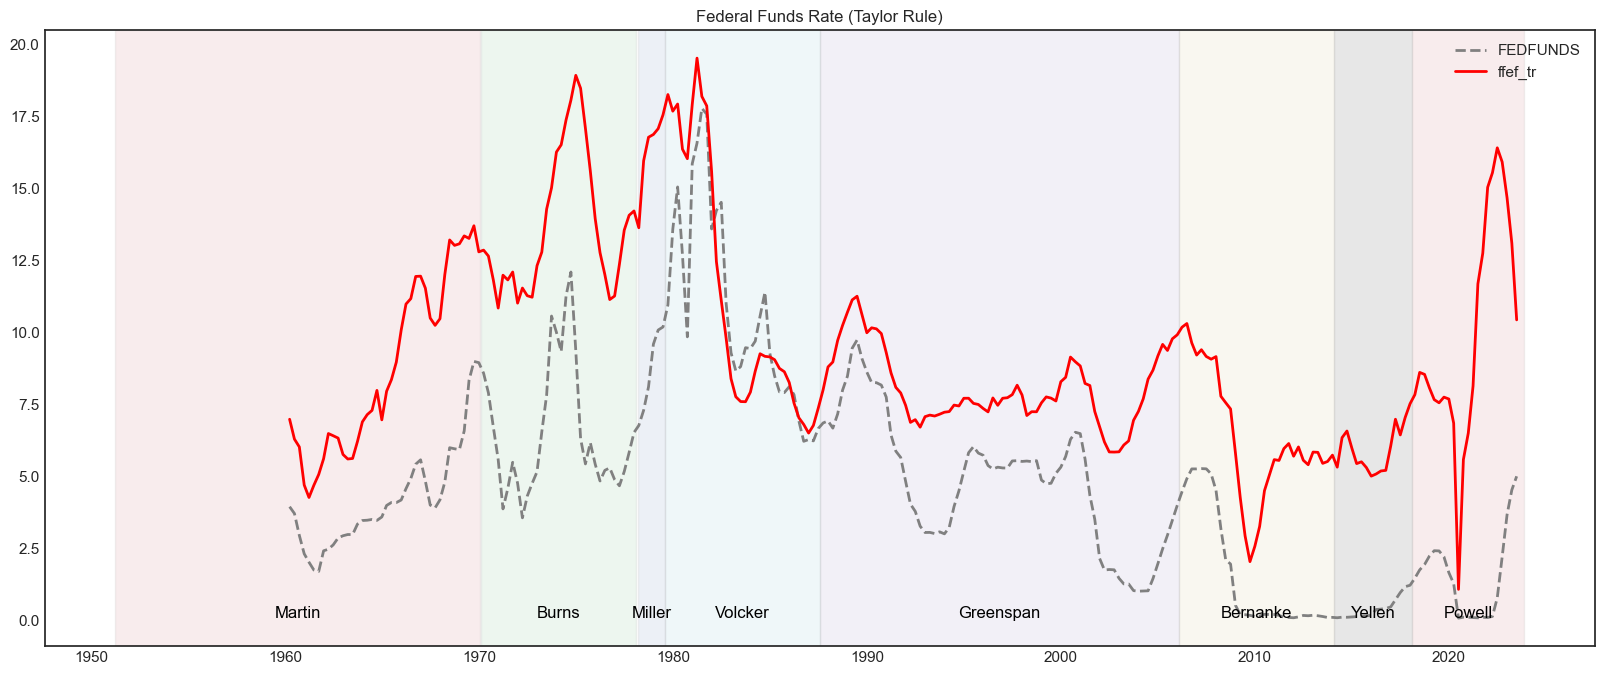

In [9]:
#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor_df
chair_df = get_fed_chair()

cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','ffef_tr']].values.min()


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr'], color='red',linewidth=2)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=12, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","ffef_tr"])
ax.set(title='Federal Funds Rate (Taylor Rule)');
#plt.legend()
plt.grid(False)
plt.show()

In [10]:
model_results(t_df['FEDFUNDS'], t_df['ffef_tr'], t_df.shape[0], 2 )

r-squared:  -1.156
adj r-squared -1.1645
mse:  28.8847
rmse:  5.3745


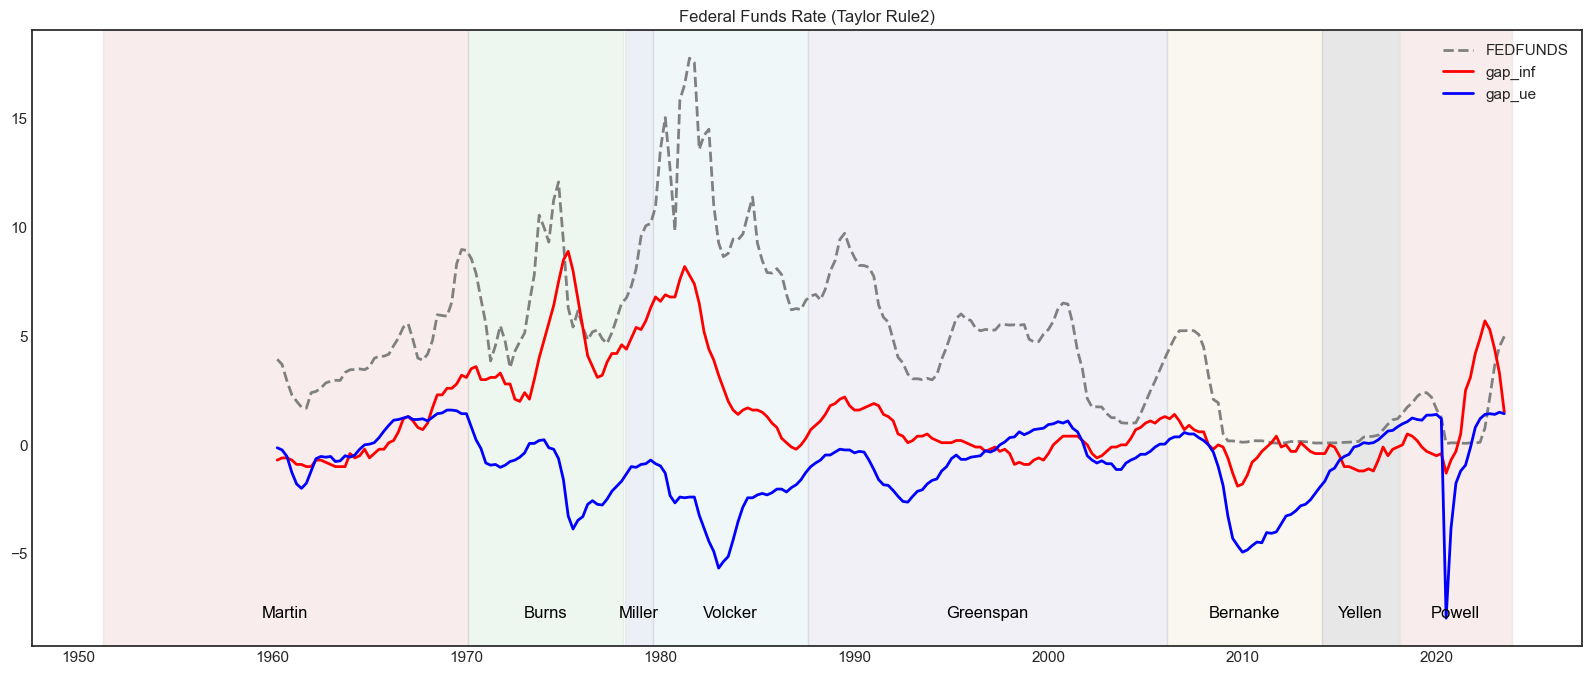

In [11]:
#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor_df
chair_df = get_fed_chair()

cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_inf','gap_ue']].values.min()


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['gap_inf'], color='red',linewidth=2)
ax.plot(t_df.index, t_df['gap_ue'], color='blue',linewidth=2)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=12, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","gap_inf",'gap_ue'])
ax.set(title='Federal Funds Rate (Taylor Rule2)');
#plt.legend()
plt.grid(False)
plt.show()

In [12]:
for i, row in chair_df.iterrows():
    print('---', row['Name'], '---')
    try:
        model_results(t_df['FEDFUNDS'][t_df['chair_name']==row['Name']], t_df['ffef_tr'][t_df['chair_name']==row['Name']], t_df.shape[0], 2 )
    except Exception as e:
        print(f"An error occurred: {e}")

--- McCabe ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Martin ---
r-squared:  -6.6656
adj r-squared -6.696
mse:  23.6637
rmse:  4.8645
--- Burns ---
r-squared:  -10.0797
adj r-squared -10.1237
mse:  54.5523
rmse:  7.3859
--- Miller ---
r-squared:  -31.2189
adj r-squared -31.3468
mse:  59.0245
rmse:  7.6827
--- Volcker ---
r-squared:  0.5022
adj r-squared 0.5002
mse:  5.7302
rmse:  2.3938
--- Greenspan ---
r-squared:  -1.6364
adj r-squared -1.6469
mse:  13.2459
rmse:  3.6395
--- Bernanke ---
r-squared:  -4.4784
adj r-squared -4.5001
mse:  23.9164
rmse:  4.8904
--- Yellen ---
r-squared:  -214.8469
adj r-squared -215.7035
mse:  30.816
rmse:  5.5512
--- Powell ---
r-squared:  -39.7773
adj r-squared -39.9391
mse:  84.9278
rmse:  9.2156


In [13]:
for i in t_df['recession_flag'].unique():
    print('---', i , '---')
    try:
        model_results(t_df['FEDFUNDS'][t_df['recession_flag']==i], t_df['ffef_tr'][t_df['recession_flag']==i], t_df.shape[0], 2 )
    except Exception as e:
        print(f"An error occurred: {e}") 

--- False ---
r-squared:  -1.7673
adj r-squared -1.7783
mse:  30.1201
rmse:  5.4882
--- True ---
r-squared:  0.1182
adj r-squared 0.1147
mse:  19.9981
rmse:  4.4719


for i, row in chair_df.iterrows():
    print('---', row['Name'], '---')
    try:
        model_results(t_df['FEDFUNDS'][t_df['chair_name']==row['Name']], t_df['ffef_tr'][t_df['chair_name']==row['Name']], t_df.shape[0], 2 )
    except Exception as e:
        print(f"An error occurred: {e}")

## Modified Taylor Rule

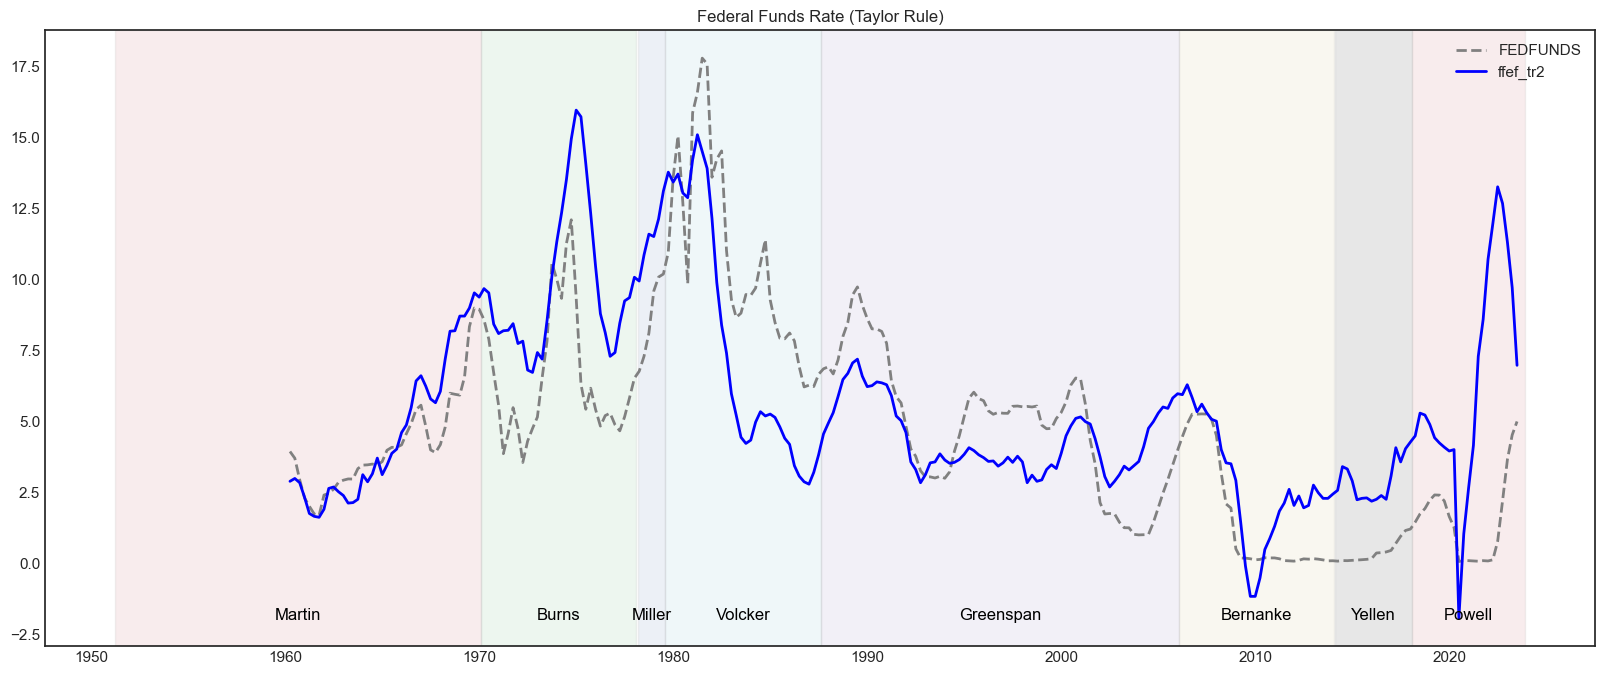

In [14]:
#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor_df
chair_df = get_fed_chair()

cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_inf','gap_gdp']].values.min()


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr2'], color='blue',linewidth=2)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=12, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","ffef_tr2"])
ax.set(title='Federal Funds Rate (Taylor Rule)');
#plt.legend()
plt.grid(False)
plt.show()

In [15]:
model_results(t_df['FEDFUNDS'], t_df['ffef_tr2'], t_df.shape[0], 2 )

r-squared:  0.3295
adj r-squared 0.3268
mse:  8.9837
rmse:  2.9973


In [16]:
t_df

,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name
DATE,,,,,,,,,,,,,
1960-03-31,3.933333,5.133333,3.873333,3517.181,3255.290989,1.3,-0.7,8.045057,-0.133333,6.972528,2.883333,False,Martin
1960-06-30,3.696667,5.233333,2.993333,3498.246,3288.916718,1.4,-0.6,6.364688,-0.233333,6.282344,2.983333,True,Martin
1960-09-30,2.936667,5.533333,2.360000,3515.385,3321.957785,1.4,-0.6,5.822687,-0.533333,6.011344,2.833333,True,Martin
1960-12-31,2.296667,6.266667,2.306667,3470.278,3353.814414,1.3,-0.7,3.472571,-1.266667,4.686285,2.316667,True,Martin
1961-03-31,2.003333,6.800000,2.350000,3493.703,3385.151548,1.1,-0.9,3.206694,-1.800000,4.253347,1.750000,False,Martin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.770000,3.600000,1.076667,21708.160,20153.810000,7.7,5.7,7.712437,1.400000,16.406219,13.250000,False,Powell
2022-09-30,2.190000,3.566667,2.663333,21851.134,20245.660000,7.3,5.3,7.929966,1.433333,15.914983,12.666667,False,Powell
2022-12-31,3.653333,3.600000,4.040000,21989.981,20334.210000,6.4,4.4,8.142785,1.400000,14.671392,11.300000,False,Powell


## Other Formulation

In [17]:
taylor1a_df = load_taylor1a()

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)


In [18]:
taylor1a_df

,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,GDPC1_log,GDPPOT_log,GDPDEF_PC1_log,UNRATE_log,FEDFUNDS_log,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name
DATE,,,,,,,,,,,,,,,,,,
1960-03-31,3.933333,5.133333,3.873333,3517.181,3255.290989,1.3,8.168254,8.091104,2.424803,2.716900,2.634284,1.731656,0.077150,-1.107462,5.814112,5.221806,False,Martin
1960-06-30,3.696667,5.233333,2.993333,3498.246,3288.916718,1.4,8.162871,8.101349,2.433613,2.723486,2.617152,1.740466,0.061522,-1.114048,5.819514,5.231729,True,Martin
1960-09-30,2.936667,5.533333,2.360000,3515.385,3321.957785,1.4,8.167745,8.111315,2.433613,2.742988,2.560066,1.740466,0.056430,-1.133550,5.816968,5.221978,True,Martin
1960-12-31,2.296667,6.266667,2.306667,3470.278,3353.814414,1.3,8.154867,8.120831,2.424803,2.789118,2.509328,1.731656,0.034037,-1.179680,5.792555,5.185697,True,Martin
1961-03-31,2.003333,6.800000,2.350000,3493.703,3385.151548,1.1,8.161576,8.130104,2.406945,2.821379,2.485184,1.713798,0.031472,-1.211941,5.764487,5.142780,False,Martin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.770000,3.600000,1.076667,21708.160,20153.810000,7.7,9.985904,9.911645,2.873565,2.610070,2.376764,2.180417,0.074259,-1.000632,6.485810,5.948364,False,Powell
2022-09-30,2.190000,3.566667,2.663333,21851.134,20245.660000,7.3,9.992466,9.916190,2.850707,2.607616,2.500616,2.157559,0.076276,-0.998178,6.452531,5.915304,False,Powell
2022-12-31,3.653333,3.600000,4.040000,21989.981,20334.210000,6.4,9.998797,9.920552,2.797281,2.610070,2.613984,2.104134,0.078245,-1.000632,6.373378,5.833939,False,Powell


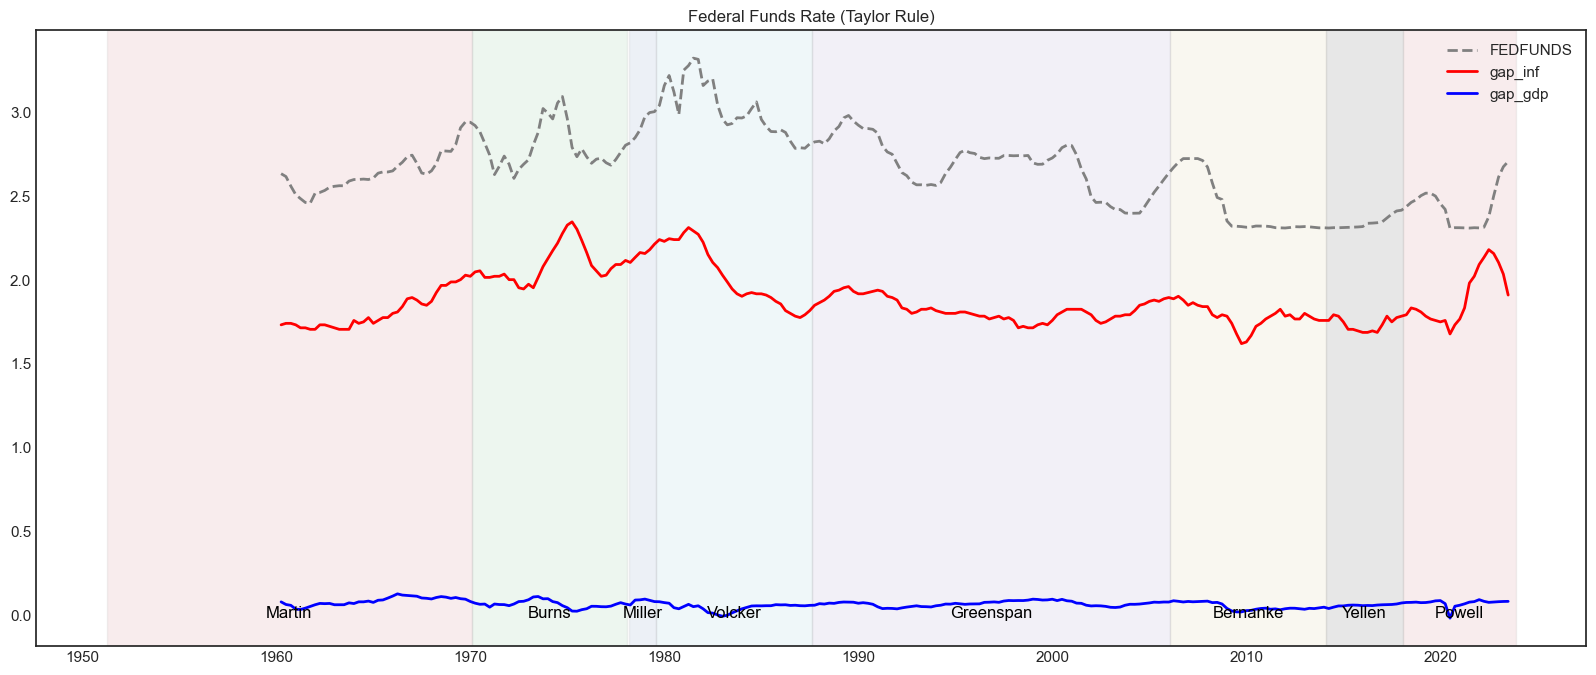

In [31]:
#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor1a_df
chair_df = get_fed_chair()

cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_inf','gap_gdp']].values.min()


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS_log'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['gap_inf'], color='red',linewidth=2)
ax.plot(t_df.index, t_df['gap_gdp'], color='blue',linewidth=2)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=12, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","gap_inf",'gap_gdp'])
ax.set(title='Federal Funds Rate (Taylor Rule)');
#plt.legend()
plt.grid(False)
plt.show()

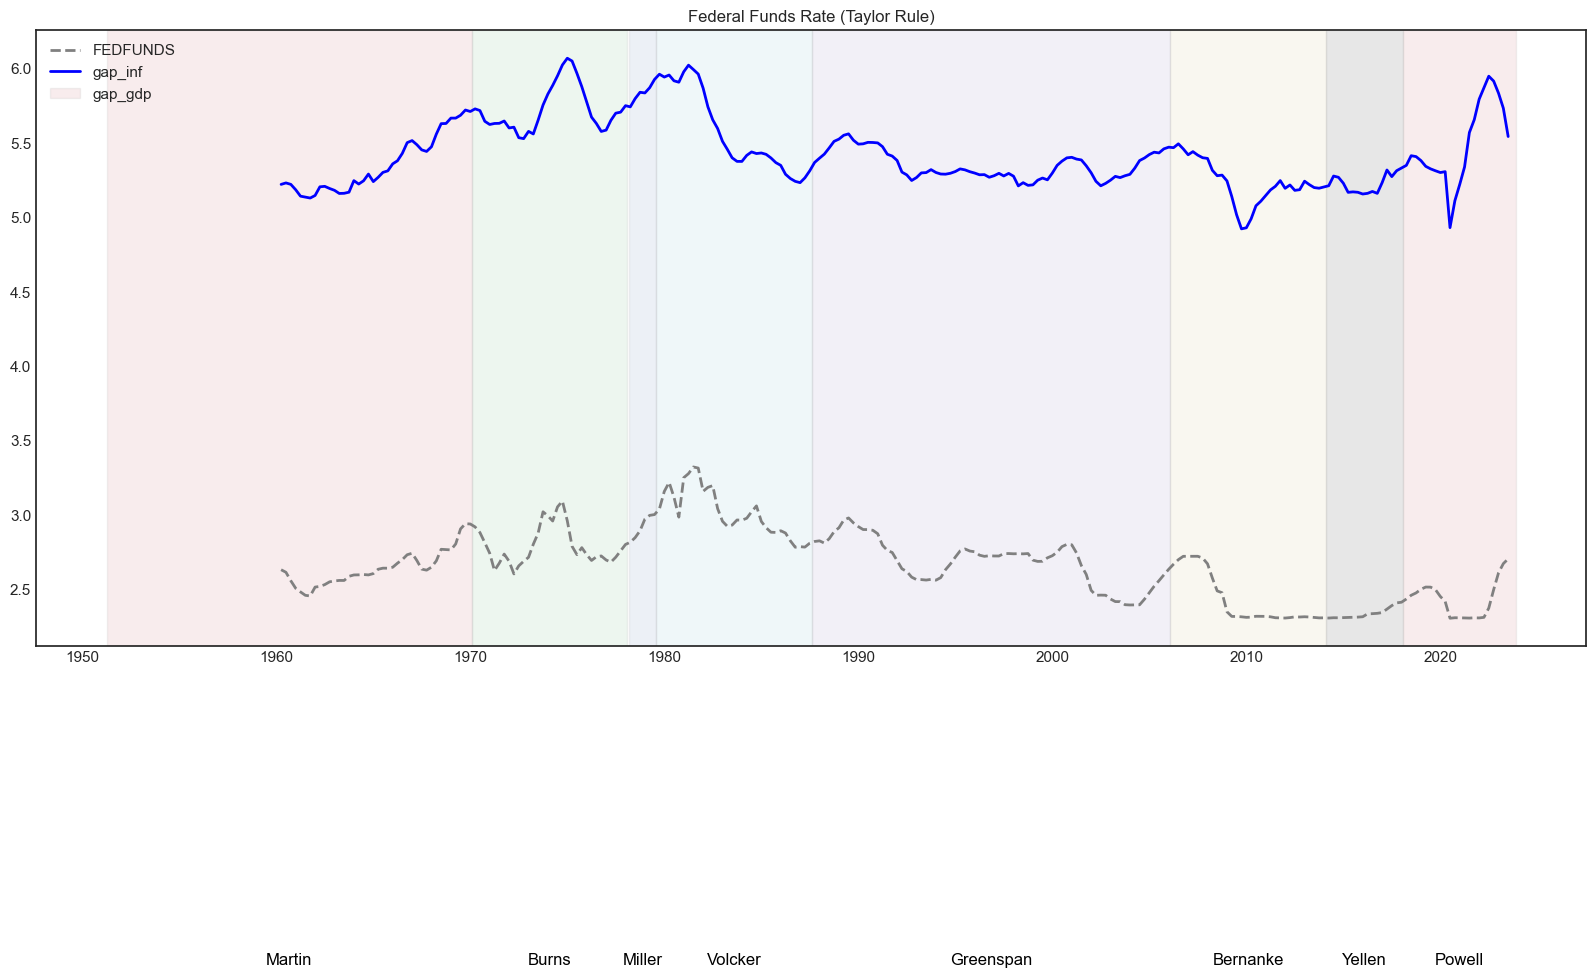

In [32]:
#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor1a_df
chair_df = get_fed_chair()

cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_inf','gap_gdp']].values.min()


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS_log'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr2'], color='blue',linewidth=2)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=12, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","gap_inf",'gap_gdp'])
ax.set(title='Federal Funds Rate (Taylor Rule)');
#plt.legend()
plt.grid(False)
plt.show()

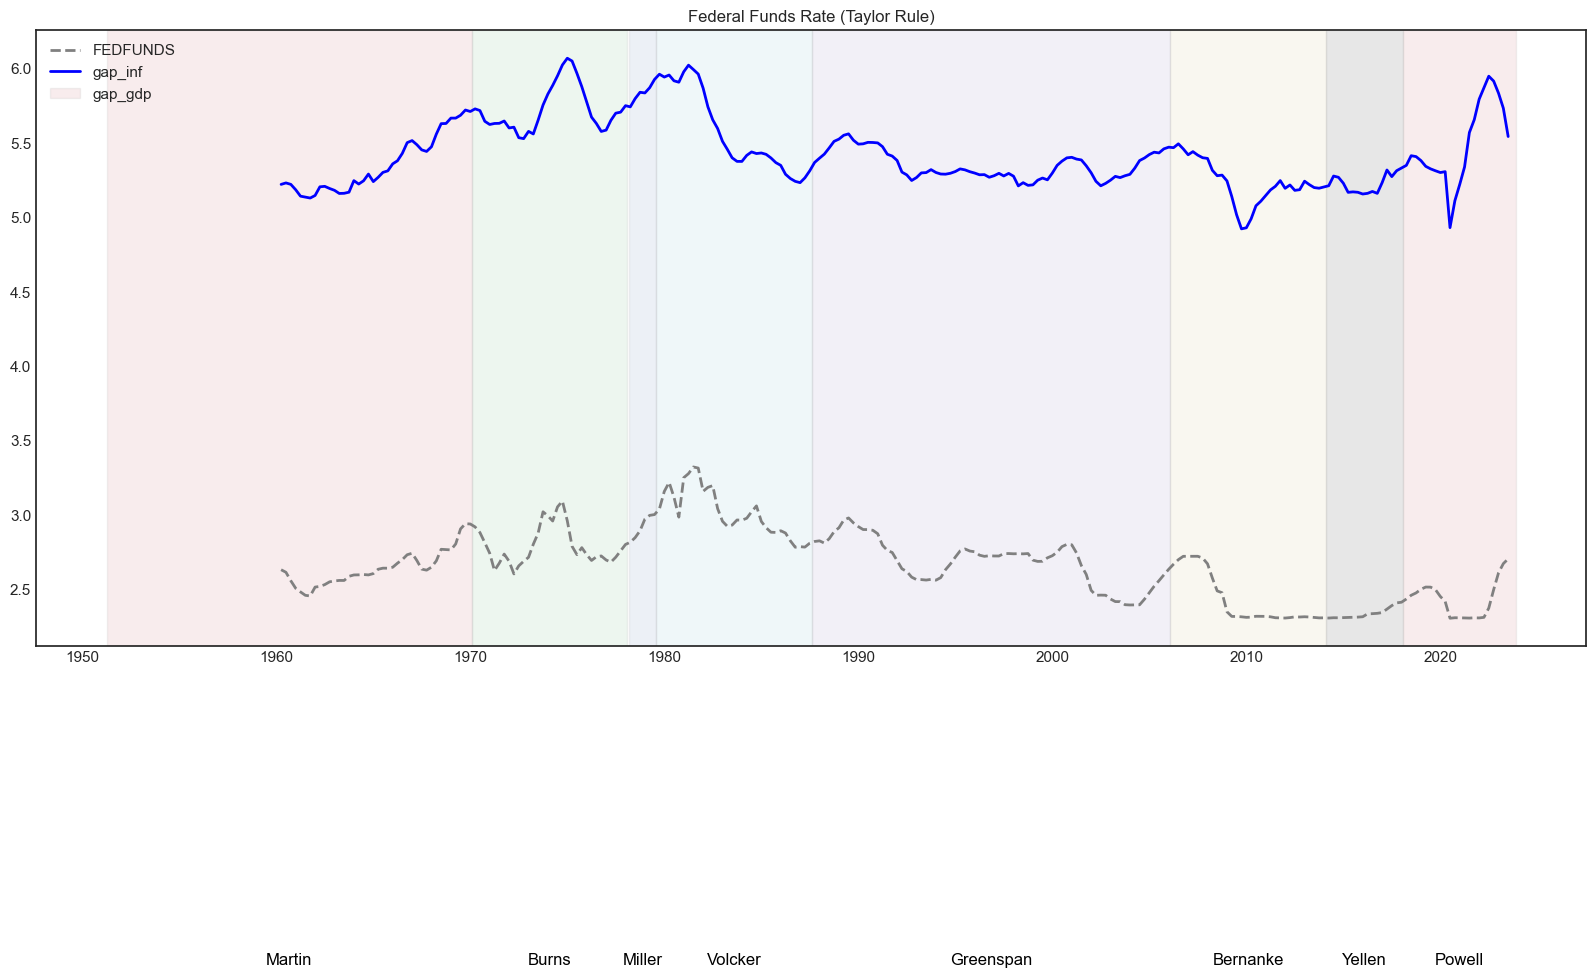

In [33]:
#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor1a_df
chair_df = get_fed_chair()

cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_inf','gap_gdp']].values.min()


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS_log'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr2'], color='blue',linewidth=2)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=12, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","gap_inf",'gap_gdp'])
ax.set(title='Federal Funds Rate (Taylor Rule)');
#plt.legend()
plt.grid(False)
plt.show()

In [22]:
for i, row in chair_df.iterrows():
    print('---', row['Name'], '---')
    try:
        model_results(t_df['FEDFUNDS'][t_df['chair_name']==row['Name']], t_df['ffef_tr2'][t_df['chair_name']==row['Name']], t_df.shape[0], 2 )
    except Exception as e:
        print(f"An error occurred: {e}")

--- McCabe ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Martin ---
r-squared:  -0.2588
adj r-squared -0.2638
mse:  3.8859
rmse:  1.9713
--- Burns ---
r-squared:  -0.0346
adj r-squared -0.0387
mse:  5.094
rmse:  2.257
--- Miller ---
r-squared:  -4.2887
adj r-squared -4.3097
mse:  9.6889
rmse:  3.1127
--- Volcker ---
r-squared:  -2.1389
adj r-squared -2.1513
mse:  36.133
rmse:  6.0111
--- Greenspan ---
r-squared:  -0.0081
adj r-squared -0.0121
mse:  5.065
rmse:  2.2506
--- Bernanke ---
r-squared:  -2.9514
adj r-squared -2.9671
mse:  17.2501
rmse:  4.1533
--- Yellen ---
r-squared:  -162.6796
adj r-squared -163.3292
mse:  23.3682
rmse:  4.8341
--- Powell ---
r-squared:  -7.3975
adj r-squared -7.4308
mse:  17.4897
rmse:  4.1821


In [23]:
for i in t_df['recession_flag'].unique():
    print('---', i , '---')
    try:
        model_results(t_df['FEDFUNDS'][t_df['recession_flag']==i], t_df['ffef_tr'][t_df['recession_flag']==i], t_df.shape[0], 2 )
    except Exception as e:
        print(f"An error occurred: {e}") 

--- False ---
r-squared:  -0.16
adj r-squared -0.1646
mse:  12.6254
rmse:  3.5532
--- True ---
r-squared:  0.024
adj r-squared 0.0201
mse:  22.1336
rmse:  4.7046


# Measure by Fed Chair

In [24]:
for i, row in chair_df.iterrows():
    print('---', row['Name'], '---')
    try:
        model_results(t_df['FEDFUNDS'][t_df['chair_name']==row['Name']], t_df['ffef_tr2'][t_df['chair_name']==row['Name']], t_df.shape[0], 2 )
    except Exception as e:
        print(f"An error occurred: {e}")

--- McCabe ---
An error occurred: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
--- Martin ---
r-squared:  -0.2588
adj r-squared -0.2638
mse:  3.8859
rmse:  1.9713
--- Burns ---
r-squared:  -0.0346
adj r-squared -0.0387
mse:  5.094
rmse:  2.257
--- Miller ---
r-squared:  -4.2887
adj r-squared -4.3097
mse:  9.6889
rmse:  3.1127
--- Volcker ---
r-squared:  -2.1389
adj r-squared -2.1513
mse:  36.133
rmse:  6.0111
--- Greenspan ---
r-squared:  -0.0081
adj r-squared -0.0121
mse:  5.065
rmse:  2.2506
--- Bernanke ---
r-squared:  -2.9514
adj r-squared -2.9671
mse:  17.2501
rmse:  4.1533
--- Yellen ---
r-squared:  -162.6796
adj r-squared -163.3292
mse:  23.3682
rmse:  4.8341
--- Powell ---
r-squared:  -7.3975
adj r-squared -7.4308
mse:  17.4897
rmse:  4.1821


In [25]:
for i in t_df['recession_flag'].unique():
    print('---', i , '---')
    try:
        model_results(t_df['FEDFUNDS'][t_df['recession_flag']==i], t_df['ffef_tr'][t_df['recession_flag']==i], t_df.shape[0], 2 )
    except Exception as e:
        print(f"An error occurred: {e}") 

--- False ---
r-squared:  -0.16
adj r-squared -0.1646
mse:  12.6254
rmse:  3.5532
--- True ---
r-squared:  0.024
adj r-squared 0.0201
mse:  22.1336
rmse:  4.7046


# Train Test

In [26]:
train_df, test_df = time_split(taylor_df)

train_df:  (203, 13)
test_df:  (51, 13)


In [27]:
model_results(train_df['FEDFUNDS'], train_df['ffef_tr'], t_df.shape[0], 2 )

r-squared:  -0.9603
adj r-squared -0.9681
mse:  22.5094
rmse:  4.7444


In [28]:
model_results(test_df['FEDFUNDS'], test_df['ffef_tr'], t_df.shape[0], 2 )

r-squared:  -39.2049
adj r-squared -39.3645
mse:  54.261
rmse:  7.3662


In [29]:
model_results(train_df['FEDFUNDS'], train_df['ffef_tr2'], t_df.shape[0], 2 )

r-squared:  0.4449
adj r-squared 0.4427
mse:  6.3743
rmse:  2.5247


In [30]:
model_results(test_df['FEDFUNDS'], test_df['ffef_tr2'], t_df.shape[0], 2 )

r-squared:  -13.3523
adj r-squared -13.4093
mse:  19.37
rmse:  4.4011
